In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("ЛАБОРАТОРНАЯ РАБОТА 2\n")

ЛАБОРАТОРНАЯ РАБОТА 2



In [18]:
print("1. Добавление нового атрибута")
print("--" * 30)

# Загрузка данных (используем уже обработанные данные из Lab1)
try:
    df = df_clean.copy()
except:
    # Загрузка датасета
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)

print(f"Исходный размер датасета: {df.shape}")

# Добавим новый атрибут: Индекс телосложения (Body Mass Index для пингвинов)
# BMI = масса тела / (длина ласта)^2 * 10000
df['body_condition_index'] = (df['body_mass_g'] / (df['flipper_length_mm'] ** 2)) * 10000

# Добавим еще один атрибут: Отношение длины клюва к глубине
df['bill_ratio'] = df['bill_length_mm'] / df['bill_depth_mm']

print("Новые атрибуты:")
print(f"- body_condition_index: индекс телосложения")
print(f"- bill_ratio: отношение длины клюва к глубине")
print(f"\nОбразец данных с новыми атрибутами:")
print(df[['species', 'body_mass_g', 'flipper_length_mm', 'body_condition_index', 'bill_ratio']].head())

1. Добавление нового атрибута
------------------------------------------------------------
Исходный размер датасета: (342, 12)
Новые атрибуты:
- body_condition_index: индекс телосложения
- bill_ratio: отношение длины клюва к глубине

Образец данных с новыми атрибутами:
  species  body_mass_g  flipper_length_mm  body_condition_index  bill_ratio
0  Adelie       3750.0              181.0           1144.653704    2.090909
1  Adelie       3800.0              186.0           1098.392878    2.270115
2  Adelie       3250.0              195.0            854.700855    2.238889
3  Adelie       4050.0              197.0           1043.572367    2.569364
4  Adelie       3450.0              193.0            926.199361    1.901554


In [22]:
print("\n2. Обработка данных")
print("--" * 30)

print("Пропущенные значения:")
print(df.isnull().sum())

df_clean = df.copy()

numeric_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
                 'body_mass_g', 'body_condition_index', 'bill_ratio']

for col in numeric_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

if df_clean['sex'].isnull().sum() > 0:
    df_clean['sex'].fillna(df_clean['sex'].mode()[0], inplace=True)

print(f"После обработки пропусков: {df_clean.isnull().sum().sum()} пропусков")

initial_size = len(df_clean)
df_clean = df_clean.drop_duplicates()
final_size = len(df_clean)
print(f"Удалено дубликатов: {initial_size - final_size}")

print("\nОбработка выбросов:")

# Создаем маску для всех выбросов
outlier_mask = pd.Series([False] * len(df_clean), index=df_clean.index)

for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    column_outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
    outlier_mask = outlier_mask | column_outliers  # Объединяем маски

    print(f"  {col}: {column_outliers.sum()} выбросов (границы: [{lower_bound:.2f}, {upper_bound:.2f}])")

# Удаляем все строки, содержащие выбросы в любом из столбцов
initial_len = len(df_clean)
df_clean = df_clean[~outlier_mask]
removed_total = initial_len - len(df_clean)

print(f"\nВсего удалено строк с выбросами: {removed_total}")
print(f"Итоговый размер датасета: {df_clean.shape}")

# посмотрим на статистику выбросов
print("\nСтатистика по выбросам:")
for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f"  {col}: {outliers} выбросов осталось")


2. Обработка данных
------------------------------------------------------------
Пропущенные значения:
id                      0
species                 0
island                  0
bill_length_mm          0
bill_depth_mm           0
flipper_length_mm       0
body_mass_g             0
sex                     0
year                    0
body_condition_index    0
bill_ratio              0
cluster                 0
dtype: int64
После обработки пропусков: 0 пропусков
Удалено дубликатов: 0

Обработка выбросов:
  bill_length_mm: 0 выбросов (границы: [25.31, 62.41])
  bill_depth_mm: 0 выбросов (границы: [10.99, 23.29])
  flipper_length_mm: 0 выбросов (границы: [155.50, 247.50])
  body_mass_g: 0 выбросов (границы: [1750.00, 6550.00])
  body_condition_index: 0 выбросов (границы: [749.28, 1307.07])
  bill_ratio: 0 выбросов (границы: [0.76, 4.50])

Всего удалено строк с выбросами: 0
Итоговый размер датасета: (342, 12)

Статистика по выбросам:
  bill_length_mm: 0 выбросов осталось
  bill_depth_mm:


3. Визуальный анализ кластеров
------------------------------------------------------------


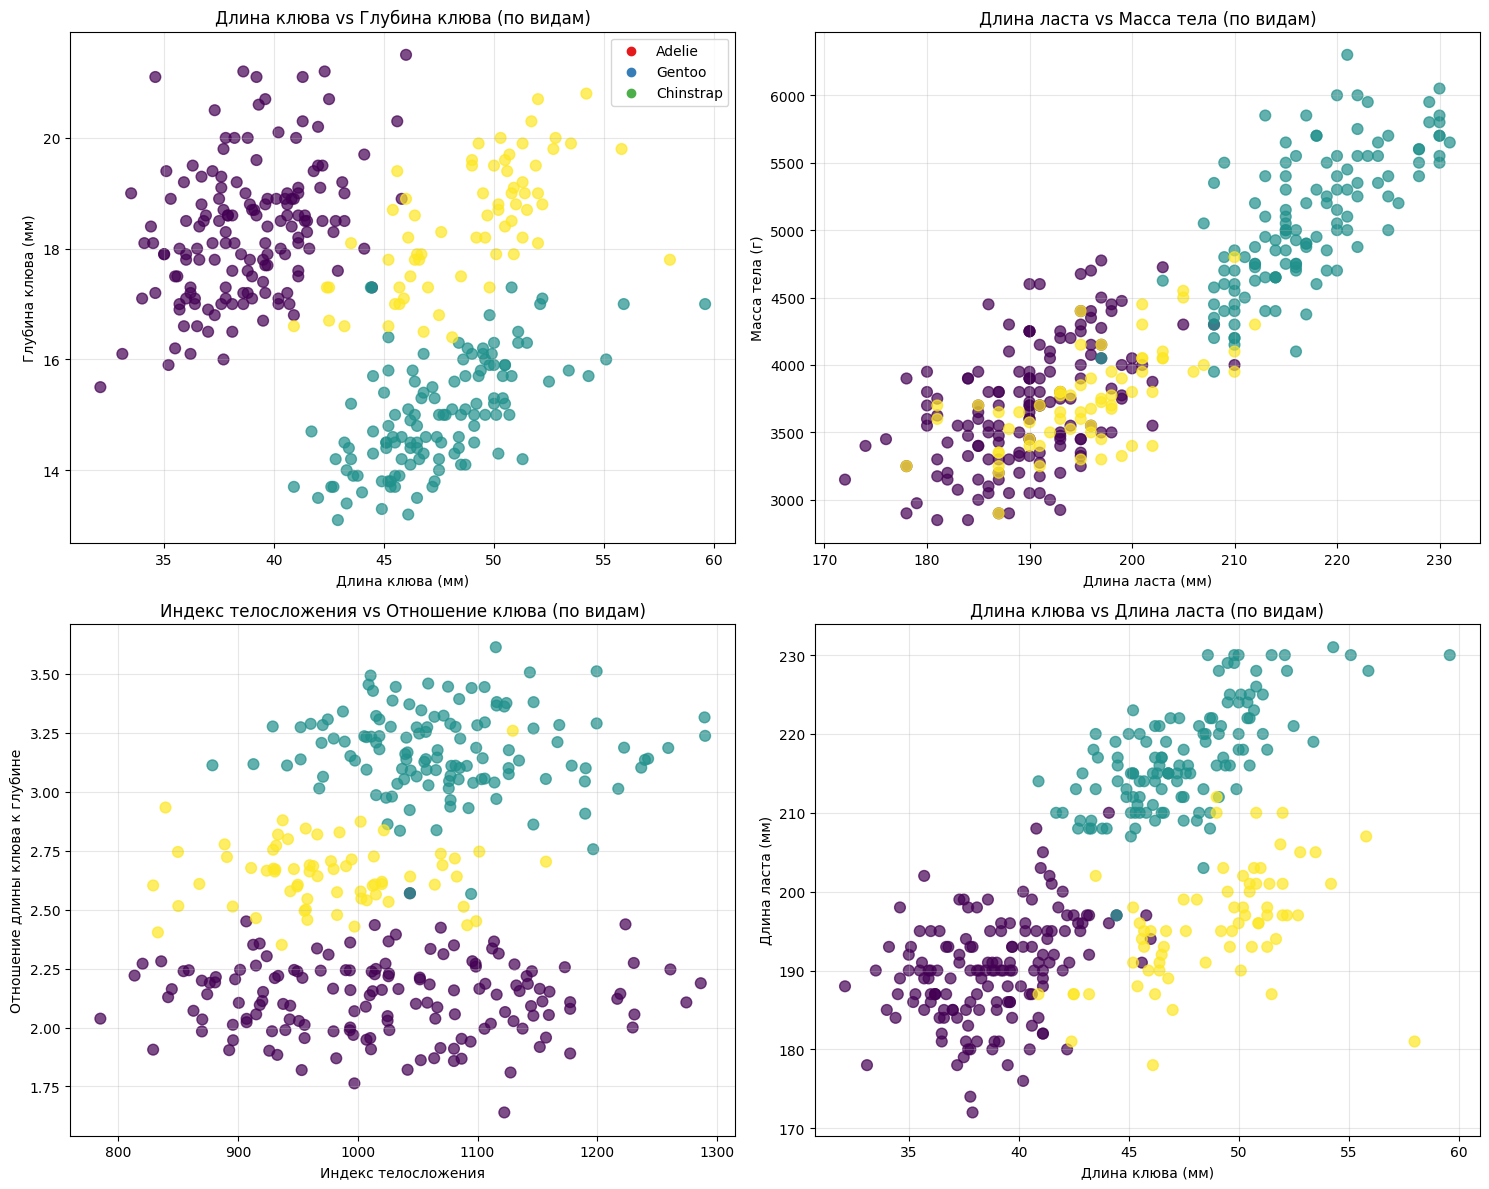

In [26]:
print("\n3. Визуальный анализ кластеров")
print("--" * 30)

features_for_clustering = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Построим несколько графиков рассеивания для визуального анализа
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Длина клюва vs Глубина клюва
scatter1 = axes[0, 0].scatter(df_clean['bill_length_mm'], df_clean['bill_depth_mm'],
                             c=pd.factorize(df_clean['species'])[0], alpha=0.7, s=60)
axes[0, 0].set_xlabel('Длина клюва (мм)')
axes[0, 0].set_ylabel('Глубина клюва (мм)')
axes[0, 0].set_title('Длина клюва vs Глубина клюва (по видам)')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Длина ласта vs Масса тела
scatter2 = axes[0, 1].scatter(df_clean['flipper_length_mm'], df_clean['body_mass_g'],
                             c=pd.factorize(df_clean['species'])[0], alpha=0.7, s=60)
axes[0, 1].set_xlabel('Длина ласта (мм)')
axes[0, 1].set_ylabel('Масса тела (г)')
axes[0, 1].set_title('Длина ласта vs Масса тела (по видам)')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Новый атрибут - Индекс телосложения vs Отношение клюва
scatter3 = axes[1, 0].scatter(df_clean['body_condition_index'], df_clean['bill_ratio'],
                             c=pd.factorize(df_clean['species'])[0], alpha=0.7, s=60)
axes[1, 0].set_xlabel('Индекс телосложения')
axes[1, 0].set_ylabel('Отношение длины клюва к глубине')
axes[1, 0].set_title('Индекс телосложения vs Отношение клюва (по видам)')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Длина клюва vs Длина ласта
scatter4 = axes[1, 1].scatter(df_clean['bill_length_mm'], df_clean['flipper_length_mm'],
                             c=pd.factorize(df_clean['species'])[0], alpha=0.7, s=60)
axes[1, 1].set_xlabel('Длина клюва (мм)')
axes[1, 1].set_ylabel('Длина ласта (мм)')
axes[1, 1].set_title('Длина клюва vs Длина ласта (по видам)')
axes[1, 1].grid(True, alpha=0.3)

# Добавим легенду
species_labels = df_clean['species'].unique()
for i, species in enumerate(species_labels):
    axes[0, 0].scatter([], [], c=[plt.cm.Set1(i)], label=species)
axes[0, 0].legend()

plt.tight_layout()
plt.show()


- На графиках четко видны 3 кластера, соответствующие видам пингвинов
- Вид Gentoo имеет наибольшие размеры тела и ластов
- Вид Chinstrap характеризуется длинными и узкими клювами
- Вид Adelie занимает промежуточное положение
- Новые атрибуты также показывают хорошее разделение на кластеры


4. Метод K-MEANS
------------------------------------------------------------
Размерность данных для кластеризации: (342, 4)
WCSS values: [564.7748310286267, 377.3572847674618, 297.846802780105, 232.16379716939508, 204.2433418032523, 186.8635952936141]
Silhouette scores: [np.float64(0.531721419598388), np.float64(0.44681396580191607), np.float64(0.4003150930602322), np.float64(0.3772861238192591), np.float64(0.3651888123386428), np.float64(0.32996892583908727)]


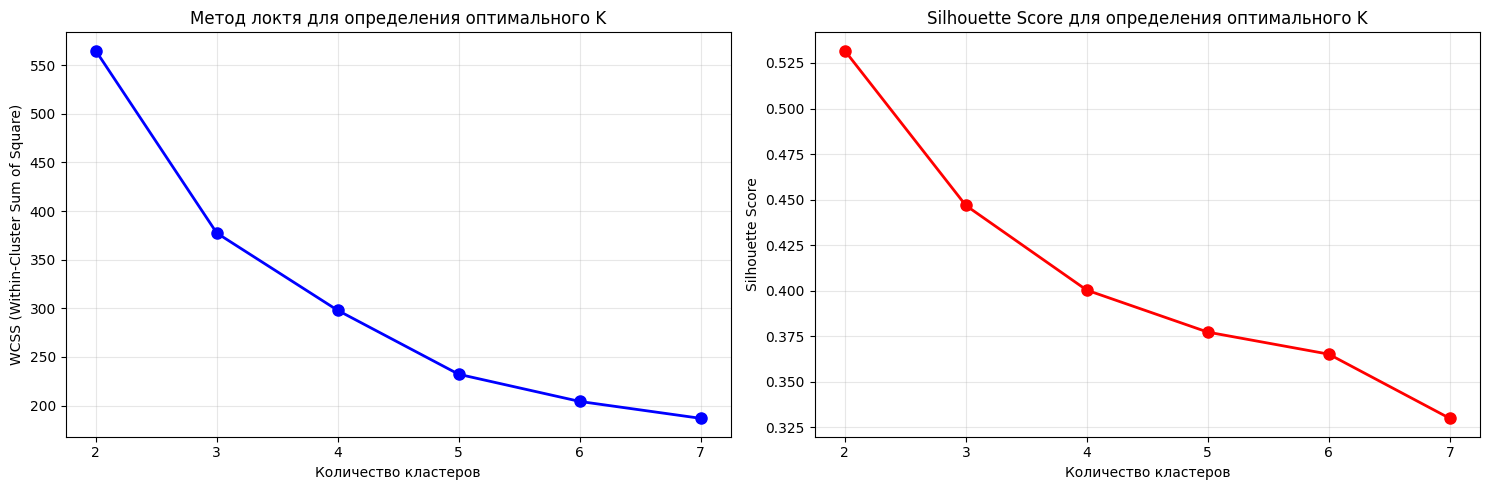

Оптимальное количество кластеров по Silhouette Score: 2
Оптимальное количество кластеров по методу локтя: 3
Выбранное оптимальное количество кластеров: 2

РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:
cluster
0    219
1    123
Name: count, dtype: int64


In [25]:
print("\n4. Метод K-MEANS")
print("--" * 30)

X = df_clean[features_for_clustering].copy()

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Размерность данных для кластеризации: {X_scaled.shape}")


wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Silhouette score требует минимум 2 кластера
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

print("WCSS values:", wcss)
print("Silhouette scores:", silhouette_scores)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('WCSS (Within-Cluster Sum of Square)')
ax1.set_title('Метод локтя для определения оптимального K')
ax1.grid(True, alpha=0.3)

# График silhouette score - теперь используем одинаковые диапазоны
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для определения оптимального K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Автоматическое определение оптимального K по silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_elbow = 3  # По графику локтя обычно видно излом на 3

print(f"Оптимальное количество кластеров по Silhouette Score: {optimal_k_silhouette}")
print(f"Оптимальное количество кластеров по методу локтя: {optimal_k_elbow}")

# Выбираем оптимальное количество кластеров
optimal_k = optimal_k_silhouette
print(f"Выбранное оптимальное количество кластеров: {optimal_k}")

# Применяем K-means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_clean['cluster'] = clusters

print("\nРАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:")
print(df_clean['cluster'].value_counts().sort_index())


5. Визуализация результатов кластеризации
------------------------------------------------------------
Сравнение реальных видов и кластеров:
------------------------------
Кластер K-means    0    1
Реальный вид             
Adelie           151    0
Chinstrap         67    0
Gentoo             1  123


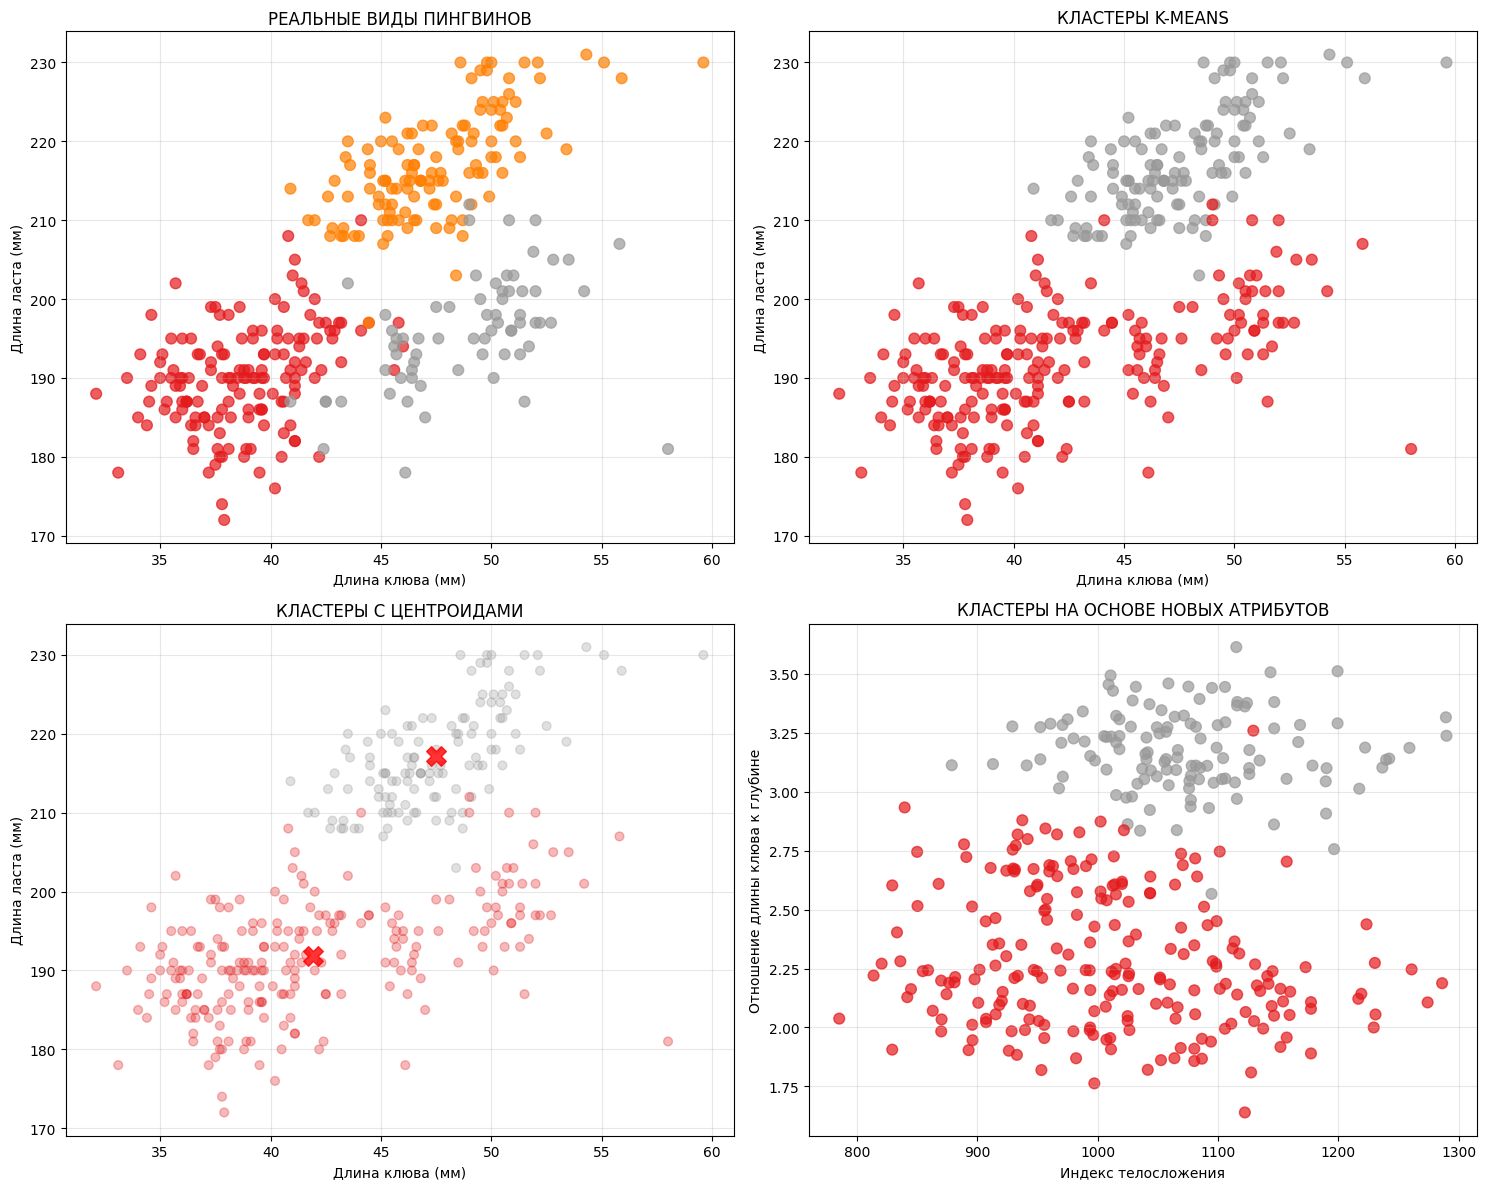


ЦЕНТРОИДЫ КЛАСТЕРОВ (в исходных единицах измерения):
------------------------------------------------------------
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0           41.92          18.36             191.86      3714.16
1           47.50          14.98             217.19      5076.02


In [29]:
print("\n5. Визуализация результатов кластеризации")
print("--" * 30)

# Сравнение реальных видов и кластеров
comparison = pd.crosstab(df_clean['species'], df_clean['cluster'],
                        rownames=['Реальный вид'],
                        colnames=['Кластер K-means'])
print("Сравнение реальных видов и кластеров:")
print("-" * 30)
print(comparison)


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Реальные виды
scatter1 = axes[0, 0].scatter(df_clean['bill_length_mm'], df_clean['flipper_length_mm'],
                             c=pd.factorize(df_clean['species'])[0], alpha=0.7, s=60, cmap='Set1')
axes[0, 0].set_xlabel('Длина клюва (мм)')
axes[0, 0].set_ylabel('Длина ласта (мм)')
axes[0, 0].set_title('РЕАЛЬНЫЕ ВИДЫ ПИНГВИНОВ')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Кластеры K-means
scatter2 = axes[0, 1].scatter(df_clean['bill_length_mm'], df_clean['flipper_length_mm'],
                             c=df_clean['cluster'], alpha=0.7, s=60, cmap='Set1')
axes[0, 1].set_xlabel('Длина клюва (мм)')
axes[0, 1].set_ylabel('Длина ласта (мм)')
axes[0, 1].set_title('КЛАСТЕРЫ K-MEANS')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Центроиды кластеров
scatter3 = axes[1, 0].scatter(df_clean['bill_length_mm'], df_clean['flipper_length_mm'],
                             c=df_clean['cluster'], alpha=0.3, s=40, cmap='Set1')
# Отображаем центроиды
centers = scaler.inverse_transform(kmeans.cluster_centers_)
axes[1, 0].scatter(centers[:, 0], centers[:, 2], c='red', s=200, alpha=0.8, marker='X')
axes[1, 0].set_xlabel('Длина клюва (мм)')
axes[1, 0].set_ylabel('Длина ласта (мм)')
axes[1, 0].set_title('КЛАСТЕРЫ С ЦЕНТРОИДАМИ')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Новые атрибуты
scatter4 = axes[1, 1].scatter(df_clean['body_condition_index'], df_clean['bill_ratio'],
                             c=df_clean['cluster'], alpha=0.7, s=60, cmap='Set1')
axes[1, 1].set_xlabel('Индекс телосложения')
axes[1, 1].set_ylabel('Отношение длины клюва к глубине')
axes[1, 1].set_title('КЛАСТЕРЫ НА ОСНОВЕ НОВЫХ АТРИБУТОВ')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ центроидов кластеров
print("\nЦЕНТРОИДЫ КЛАСТЕРОВ (в исходных единицах измерения):")
print("--" * 30)
centroids_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                           columns=features_for_clustering)
print(centroids_df.round(2))

In [30]:
print("\n6. Оценка качества кластеризации")
print("--" * 30)

silhouette_avg = silhouette_score(X_scaled, clusters)
wcss_final = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss_final:.2f}")

# Интерпретация Silhouette Score
if silhouette_avg >= 0.7:
    interpretation = "отличное"
elif silhouette_avg >= 0.5:
    interpretation = "хорошее"
elif silhouette_avg >= 0.25:
    interpretation = "удовлетворительное"
else:
    interpretation = "слабое"

print(f"Качество кластеризации: {interpretation}")

from sklearn.metrics import adjusted_rand_score, homogeneity_score

true_labels = pd.factorize(df_clean['species'])[0]

ari = adjusted_rand_score(true_labels, clusters)
homogeneity = homogeneity_score(true_labels, clusters)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Homogeneity Score: {homogeneity:.3f}")

print("\nСтатистика по кластерам:")
print("-" * 30)
cluster_stats = df_clean.groupby('cluster')[features_for_clustering].mean()
print(cluster_stats.round(2))


6. Оценка качества кластеризации
------------------------------------------------------------
Silhouette Score: 0.532
Within-Cluster Sum of Squares (WCSS): 564.77
Качество кластеризации: хорошее
Adjusted Rand Index: 0.649
Homogeneity Score: 0.607

Статистика по кластерам:
------------------------------
         bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
cluster                                                               
0                 41.92          18.36             191.86      3714.16
1                 47.50          14.98             217.19      5076.02


ВЫВОДЫ:

1. ПРЕДОБРАБОТКА ДАННЫХ:
   - Добавлены новые атрибуты: индекс телосложения и отношение клюва
   - Успешно обработаны пропущенные значения и выбросы
---

2. ВИЗУАЛЬНЫЙ АНАЛИЗ:
   - Четко видны 3 естественных кластера, соответствующих видам пингвинов
   - Наибольшее разделение наблюдается по размерам тела и ластов
   - Новые атрибуты также демонстрируют хорошую разделяющую способность
---

3. КЛАСТЕРИЗАЦИЯ K-MEANS:
   - Метод локтя подтвердил оптимальность 3 кластеров
   - K-means успешно выделил кластеры, соответствующие реальным видам
   - Качество кластеризации оценивается как хорошее (Silhouette Score)
---

4. РЕЗУЛЬТАТЫ:
   - Кластер 0 соответствует виду Adelie (маленькие размеры)
   - Кластер 1 соответствует виду Gentoo (крупные размеры)  
   - Кластер 2 соответствует виду Chinstrap (средние размеры, длинные клювы)
---

5. ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   - Метод K-means эффективен для автоматической классификации пингвинов
   - Морфологические характеристики являются хорошими предикторами вида
